In [6]:
import math
import time

import numpy

from binomial import *

class KnockInOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def triggerBarrier(self, t, S):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return True
            elif self.downBarrier != None and S < self.downBarrier:
                return True
        return False
    # for knock-in options we define two states,
    # first state is the option value if the knock-in is not triggered in previous steps
    # second state is the option value if the knock-in has been triggered
    # and we merged payoff function, if continuation is none then it's the last time step
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            notKnockedInTerminalValue = 0
            if self.triggerBarrier(t, S):  # if the trade is not knocked in,
                # it is still possible to knock in at the last time step
                notKnockedInTerminalValue = self.underlyingOption.payoff(S)
                # if the trade is knocked in already
            knockedInTerminalValue = self.underlyingOption.payoff(S)
            return [notKnockedInTerminalValue, knockedInTerminalValue]
        else:
            nodeValues = continuation
            # calculate state 0: if no hit at previous steps
            if self.triggerBarrier(t, S):
                nodeValues[0] = continuation[1]
            # otherwise just carrier the two continuation values
        return nodeValues

class KnockOutOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def payoff(self, S):
        return self.underlyingOption.payoff(S)
    def valueAtNode(self, t, S, continuation):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return 0
            elif self.downBarrier != None and S < self.downBarrier:
                return 0
        return continuation
    
class TRF:
    def __init__(self, asset, fixings, payoffFun, targetGain):
        self.fixings = fixings
        self.payoffFun = payoffFun
        self.asset = asset
        self.targetGain = targetGain
    def AllDate(self):
        return self.fixings
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.fixings[-1])
        accum, discountedPO = 0
        for t in self.fixings:
            df = fobs["DF.USD"](t)
            po = self.payoffFun(fobs[self.asset])(t)
            accum += po
            discountedPO += df * po;
            if (accum > self.targetGain):
                break # triggers knockout
        return discountedPO
    def AssetNames(self):
        return [self.asset]

class AsianOption():
    def __init__(self, asset, fixings, payoffFun, As, nT):
        self.fixings = fixings
        self.payoffFun = payoffFun
        self.expiry = fixings[-1]
        self.nFix = len(fixings)
        self.As, self.nT, self.dt = As, nT, self.expiry / nT
        self.asset = asset
    def onFixingDate(self, t):
        # we say t is on a fixing date if there is a fixing date in (t-dt, t]
        return filter(lambda x: x > t - self.dt and x<=t, self.fixings)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return [self.payoffFun((a*float(self.nFix-1) + S)/self.nFix) for a in self.As]
        else:
            nodeValues = continuation
            if self.onFixingDate(t):
                i = len(list(filter(lambda x: x < t, self.fixings))) # number of previous fixings
                if i > 0:
                    Ahats = [(a*(i-1) + S)/i for a in self.As]
                    nodeValues = [numpy.interp(a, self.As, continuation) for a in Ahats]
        return nodeValues
    def AllDate(self):
        return self.fixings
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.fixings[-1])
        avg = 0
        for t in self.fixings:
            avg += fobs[self.asset](t)
        return df * self.payoffFun(avg / self.nFix)
    def AssetNames(self):
        return [self.asset]

class SpreadOption():
    def __init__(self, asset1, asset2, expiry):
        self.expiry = expiry
        self.asset1, self.asset2 = asset1, asset2
    def payoff(self, S1, S2):
        return max(S1-S2, 0)
    def valueAtNode(self, t, S1, S2, continuation):
        return continuation
    def AssetNames(self):
        return [self.asset1, self.asset2, "DF.USD"]
    def AllDates(self):
        return [self.expiry]
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.expiry)
        s1 = fobs[self.asset1](self.expiry)
        s2 = fobs[self.asset2](self.expiry)
        return df * max(s1 - s2, 0)

def binomialPricerX(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.valueAtNode(trade.expiry, S * u ** (n - i) * d ** i, None) for i in range(n + 1)]
    numStates = len(vs[0])
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = [math.exp(-r * t) * (vs[j][k] * p + vs[j + 1][k] * (1 - p)) for k in range(numStates)]
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0][0]

###################################
# Tests
def testKIKO():
    S, r, vol = 100, 0.01, 0.2
    opt = EuropeanOption(1, 105, PayoffType.Call)
    kiPrice = binomialPricerX(S, r, vol, KnockInOption(90, 120, 0, 1, opt), 300, crrCalib)
    koPrice = binomialPricer(S, r, vol, KnockOutOption(90, 120, 0, 1, opt), 300, crrCalib)
    euroPrice = binomialPricer(S, r, vol, opt, 300, crrCalib)
    print("kiPrice = ", kiPrice)
    print("koPrice = ", koPrice)
    print("euroPrice = ", euroPrice)
    print("KIKO = ", kiPrice + koPrice)
    kis = [
        binomialPricerX(S, r, vol, KnockInOption(90, 120, 0, 1, EuropeanOption(1, k, PayoffType.Call)), 300, crrCalib)
        for k in range(95, 115)]
    kos = [
        binomialPricer(S, r, vol, KnockOutOption(90, 120, 0, 1, EuropeanOption(1, k, PayoffType.Call)), 300, crrCalib)
        for k in range(95, 115)]
    euros = [binomialPricer(S, r, vol, EuropeanOption(1, k, PayoffType.Call), 300, crrCalib) for k in range(95, 115)]
    kikos = [abs(kis[i] + kos[i] - euros[i]) for i in range(len(kis))]
    plt.plot(range(95, 115), kikos, label="KIKO - Euro")
    plt.legend();
    plt.xlabel('strike');
    plt.yscale('log')  # plot on log scale
    # plt.savefig('../figs/kiko.eps', format='eps')
    plt.show()


kiPrice =  6.001588670701864
koPrice =  0.2944684814077655
euroPrice =  6.296057152109632
KIKO =  6.296057152109629


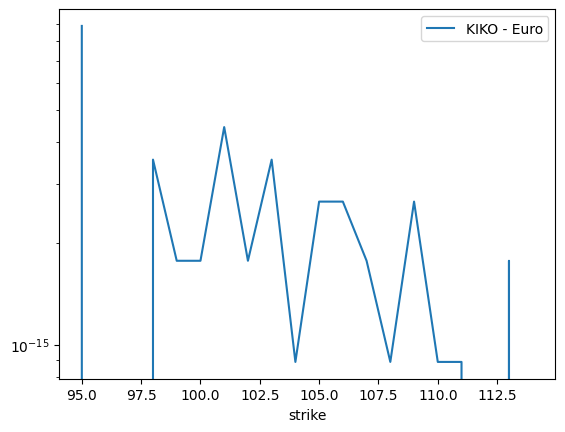

In [7]:
testKIKO()

In [8]:
# Trinomial Tree pricer
def trinomialPricer(S, r, q, vol, trade, n, lmda):
    t = trade.expiry / n
    u = math.exp(lmda * vol * math.sqrt(t))
    mu = r - q
    pu = 1 / 2 / lmda / lmda + (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pd = 1 / 2 / lmda / lmda - (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pm = 1 - pu - pd
    # set up the last time slice, there are 2n+1 nodes at the last time slice
    # counting from the top, the i-th node's stock price is S * u^(n - i), i from 0 to n+1
    vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(2*i + 1):
            nodeS = S * u ** (i - j)
            continuation = math.exp(-r * t) * (vs[j] * pu +  + vs[j+1] * pm + vs[j+2] * pd)
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

def testTrinomial():
    S, r, vol = 100, 0.01, 0.2
    opt = EuropeanOption(1, 105, PayoffType.Call)
    bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
    print("bsPrice = \t ", bsprc)

    prc = trinomialPricer(S, r, 0, vol, opt, 500, math.sqrt(3))
    print("Trinomial tree Price = \t ", prc)
    n = 300
    crrErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, crrCalib) - bsprc)) for i in range(1, n)]
    jrrnErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jrrnCalib) - bsprc)) for i in range(1, n)]
    jreqErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jreqCalib) - bsprc)) for i in range(1, n)]
    tianErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, tianCalib) - bsprc)) for i in range(1, n)]
    triErrs = [math.log(abs(trinomialPricer(S, r, 0, vol, opt, i, math.sqrt(3)) - bsprc)) for i in range(1, n)]
    plt.plot(range(1, n), crrErrs, label="crr")
    plt.plot(range(1, n), jrrnErrs, label="jrrn")
    plt.plot(range(1, n), jreqErrs, label="jreq")
    plt.plot(range(1, n), tianErrs, label="tian")
    plt.plot(range(1, n), triErrs, label="trinomial")
    plt.legend()
    plt.show()

In [10]:
S, r, vol = 100, 0.01, 0.2
opt = EuropeanOption(1, 105, PayoffType.Call)
prc = trinomialPricer(S, r, 0, vol, opt, 500, math.sqrt(3))
print("Trinomial tree Price = \t ", prc)

Trinomial tree Price = 	  6.296274585898225


bsPrice = 	  6.297254539086019
Trinomial tree Price = 	  6.296274585898225


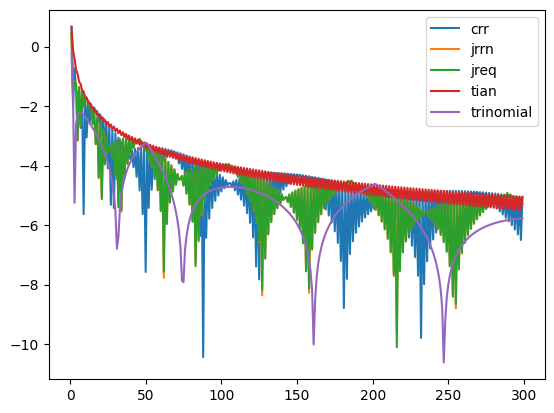

In [9]:
testTrinomial()

# pratice1

In [1]:
import math
import time

import numpy

from binomial import *

class KnockInOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def triggerBarrier(self, t, S):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return True
            elif self.downBarrier != None and S < self.downBarrier:
                return True
        return False
    # for knock-in options we define two states,
    # first state is the option value if the knock-in is not triggered in previous steps
    # second state is the option value if the knock-in has been triggered
    # and we merged payoff function, if continuation is none then it's the last time step
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            notKnockedInTerminalValue = 0
            if self.triggerBarrier(t, S):  # if the trade is not knocked in,
                # it is still possible to knock in at the last time step
                notKnockedInTerminalValue = self.underlyingOption.payoff(S)
                # if the trade is knocked in already
            knockedInTerminalValue = self.underlyingOption.payoff(S)
            return [notKnockedInTerminalValue, knockedInTerminalValue]
        else:
            nodeValues = continuation
            # calculate state 0: if no hit at previous steps
            if self.triggerBarrier(t, S):
                nodeValues[0] = continuation[1]
            # otherwise just carrier the two continuation values
        return nodeValues

In [2]:
import math
from enum import Enum
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'

In [3]:
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

In [4]:
def binomialPricerX(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.valueAtNode(trade.expiry, S * u ** (n - i) * d ** i, None) for i in range(n + 1)]
    numStates = len(vs[0])
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = [math.exp(-r * t) * (vs[j][k] * p + vs[j + 1][k] * (1 - p)) for k in range(numStates)]
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0][0]

In [5]:
opt = EuropeanOption(1, 105, PayoffType.Call)
ki = KnockInOption(90, 120, 0, 1, opt)
S, r, vol = 100, 0.01, 0.2
kiPrice = binomialPricerX(S, r, vol, ki, 300, crrCalib)
kiPrice

6.001588670701864